# Multi-Table Delete

We know how to delete data from a single table, however, if you are confronted with a situation where you want to delete data from one table and also any related data from other tables, you can employ the multi-table delete queries. 

> * **ORDER BY** and **LIMIT** clauses can’t be used with multi-table deletes.
> * **we can’t delete into a table that is also being read from a subquery**. 

**OLD Syntax**:
```
DELETE T1, T2
FROM T1, T2, T3
WHERE <condition>
```

**NEW Syntax**:
```
DELETE FROM T1, T2
USING T1, T2, T3
WHERE <condition>
```

**Examples**:

```mysql

-- Query 1
DELETE Actors, DigitalAssets   -- Mention tables to delete rows from
FROM Actors   -- The inner join creates a derived table with matching rows from both tables    
INNER JOIN DigitalAssets
ON Actors.Id = DigitalAssets.ActorId
WHERE AssetType = "Twitter";

-- Query 2
DELETE FROM Actors, DigitalAssets
USING Actors        
INNER JOIN DigitalAssets
ON Actors.Id = DigitalAssets.ActorId
WHERE AssetType = "Twitter";

-- Query 3
DELETE Actors 
FROM Actors 
WHERE EXISTS ( SELECT * 
               FROM Actors 
               INNER JOIN DigitalAssets
               ON  Id = ActorId 
               WHERE AssetType="Twitter");

-- Query 4
DELETE Actors 
FROM Actors 
WHERE EXISTS (SELECT * 
              FROM DigitalAssets 
              WHERE ActorId = Id AND AssetType = "Twitter");

-- Query 5
DELETE Actors, DigitalAssets   -- specify the tables to delete from
FROM Actors, DigitalAssets   -- reference tables
WHERE ActorId = Id   -- conditions to narrow down rows         
AND FirstName = "Johnny"
AND AssetType != "Pinterest";

```


# Multi-Table Update

We have an equivalent of updating multiple tables just as we can delete from multiple tables.

```mysql


UPDATE 
Actors INNER JOIN DigitalAssets 
ON Id = ActorId 
SET FirstName = UPPER(FirstName), SecondName = UPPER(SecondName), URL = UPPER(URL) 
WHERE AssetType = "Facebook";

-- Similarly to multi-delete, we can’t update a table that is also being read from in a subquery.

UPDATE  Actors, DigitalAssets
SET FirstName = UPPER(FirstName), SecondName = UPPER(SecondName), URL = UPPER(URL) 
WHERE AssetType = "Facebook"
AND ActorId = Id;
```

# Insert Using Select

* MySQL provides us the facility to insert several rows from another table into an existing table using a combination of select and insert statements. 
* In fact, we can also create a table on the fly and fill it up with rows from another table.
* Note that it copies the data only, not the constraints.

**Syntax to Insert Data from an Existing Table**
```
INSERT INTO table1 (col1, col2)
SELECT col3, col4
FROM table2;
```

```mysql
-- Query 1
CREATE TABLE Names (name VARCHAR(20),
                    PRIMARY KEY(name));

-- Query 2
INSERT INTO Names(name) 
SELECT SecondName FROM Actors;

-- Query 3
INSERT IGNORE INTO Names(name) 
SELECT SecondName 
FROM Actors WHERE Id = 1;
```

* Trying to add a duplicate rows result in an error. MySQL provides a way to bypass this error and continue execution using the `IGNORE` clause. 
* It doesn’t mean a duplicate row is added to the table, rather it means that MySQL issues a warning instead of issuing an error and aborting.

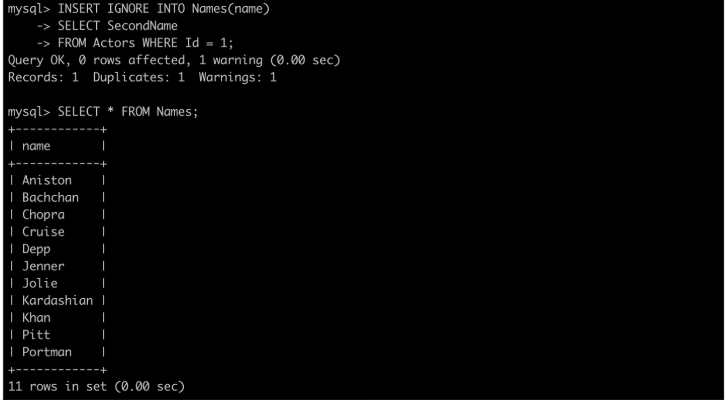

**Syntax to insert data while creating the table**
```
CREATE TABLE newTable (col1 <datatype>, <col2>)
SELECT col3, col4
FROM table2;
```

```mysql
-- Query 4
CREATE TABLE MyTempTable SELECT * FROM Actors;

-- Query 5
CREATE TABLE NamesWithDoBs ( 
Id INT AUTO_INCREMENT,
Name VARCHAR(20) NOT NULL DEFAULT "unknown",  
DoB DATE,  
PRIMARY KEY(Id), KEY(Name), KEY(DoB))  SELECT FirstName, DoB FROM Actors;
```


**Create a copy of an existing table without the data using the `LIKE` operator**

```mysql
CREATE TABLE CopyOfActors LIKE Actors;
```

* The copy table doesn’t contain any data, but its structure is exactly the same as the source table. 
* The primary keys and any indexes defined on the source table are also defined on the copy table.

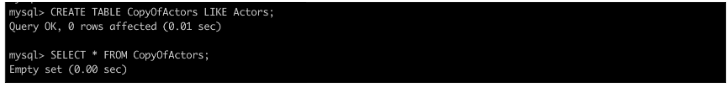

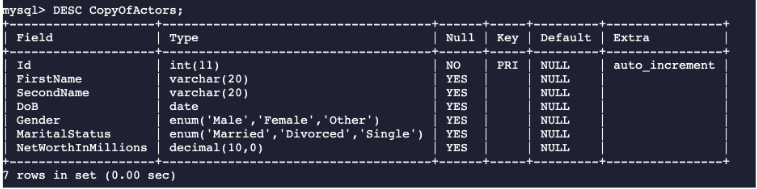

# Replace

* `REPLACE` is much like the `INSERT` statement with one key difference: we can’t insert a row if a table already contains a row with the same primary key.
* However, `REPLACE` allows us the convenience of adding a row with the same primary key as an existing row in the table.
* Under the hood, `REPLACE` deletes the row and then adds the new row, thereby maintaining the primary key constraint at all times.
* Sure, we can also use the `UPDATE` clause to achieve the same effect.
* However, `REPLACE` can be useful in automated scripts where it is not known ahead of time if a particular table already contains a particular primary key.
* If it doesn’t, the replacement behaves like an insertion, otherwise, it deletes and writes in the new row with the same primary key.

**Syntax**

```
REPLACE INTO table (col1, col2, … coln)
VALUES (val1, val2, … valn)
WHERE <condition>
```

**Examples**:

```mysql

REPLACE INTO
Actors (Id, FirstName, SecondName,DoB, Gender, MaritalStatus, NetworthInMillions)
VALUES (3, "George", "Clooney", "1961-05-06","Male", "Married", 500.00);

-- To see the result of the query
SELECT * FROM Actors;


-- The rest of the columns not specified in the query end up taking the default value which is NULL. 
REPLACE INTO 
Actors (Id)
VALUES (3);

-- To see the result of the query
SELECT * FROM Actors;


REPLACE INTO  Actors 
SET id = (SELECT Id 
          FROM Actors 
          WHERE FirstName="Brad");
```

* The columns not specified in the query end up taking the default value which is `NULL`.
* If a table doesn’t have a primary key defined, `REPLACE` behaves exactly like an INSERT. Without a primary key `REPLACE` can’t uniquely identify a row to replace.
* Remember that when inserting the duplicate row using the `INSERT IGNORE` clause, the duplicate row is ignored and not added to the table whereas when using `REPLACE`, the existing row is deleted and the duplicate row is added to the table.

Similar to multi-delete and update, **we can’t replace into a table that is also being read from a subquery**. 

For instance, the following query, which replaces the ID of a row with itself, gives an error:

```mysql
REPLACE INTO  Actors 
SET id = (SELECT Id 
       FROM Actors 
       WHERE FirstName="Brad");
```

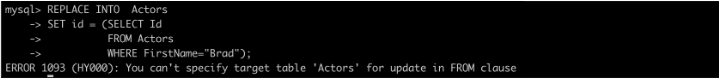